# Выгрузка курсов валют (GetCursOnDateXML)
Измените даты и путь к CSV в коде ниже, затем выполните ячейку, чтобы получить курсы валют ЦБ РФ и сохранить их в файл.

In [1]:

import datetime as dt
import csv
import xml.etree.ElementTree as ET
from pathlib import Path
from typing import Any, Dict, Iterable, List, Optional

import requests

timezone = dt.timezone.utc

try:
    import pandas as pd  # type: ignore
except Exception:
    pd = None

try:
    from IPython.display import display  # type: ignore
except Exception:  # pragma: no cover - outside notebook display falls back to print
    def display(obj):  # type: ignore
        print(obj)

CBR_ENDPOINT = "https://cbr.ru/DailyInfoWebServ/DailyInfo.asmx"

def _dt(value: dt.date | str) -> str:
    if isinstance(value, dt.datetime):
        value = value.date()
    if isinstance(value, dt.date):
        value = value.isoformat()
    if "T" not in value:
        value = f"{value}T00:00:00"
    return value

def _ensure_date(value: dt.date | str) -> dt.date:
    if isinstance(value, dt.datetime):
        return value.date()
    if isinstance(value, dt.date):
        return value
    return dt.date.fromisoformat(str(value)[:10])

def _soap12_envelope(method: str, body_xml: str) -> str:
    return f"""<?xml version="1.0" encoding="utf-8"?>
<soap12:Envelope xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
                 xmlns:xsd="http://www.w3.org/2001/XMLSchema"
                 xmlns:soap12="http://www.w3.org/2003/05/soap-envelope">
  <soap12:Body>
    <{method} xmlns="http://web.cbr.ru/">
      {body_xml}
    </{method}>
  </soap12:Body>
</soap12:Envelope>""".strip()

def _post_soap12(method: str, body_xml: str, timeout: int = 30) -> requests.Response:
    envelope = _soap12_envelope(method, body_xml)
    headers = {"Content-Type": "application/soap+xml; charset=utf-8"}
    resp = requests.post(CBR_ENDPOINT, data=envelope.encode("utf-8"), headers=headers, timeout=timeout)
    resp.raise_for_status()
    return resp

def _inner_text(elem: Optional[ET.Element]) -> Optional[str]:
    if elem is None:
        return None
    if list(elem):
        return "".join(ET.tostring(child, encoding="unicode") for child in elem).strip()
    text = "".join(elem.itertext()).strip()
    return text or None

def _clean_tag(tag: str) -> str:
    return tag.split("}", 1)[-1]

def _parse_rows_from_inner_xml(xml_text: str) -> List[Dict[str, Any]]:
    root = ET.fromstring(xml_text)
    node = root
    for _ in range(4):
        children = list(node)
        if not children:
            break
        if len(children) == 1 and list(children[0]):
            node = children[0]
            continue
        break

    rows: List[Dict[str, Any]] = []
    for row in node:
        row_dict: Dict[str, Any] = {}
        for field in row:
            key = _clean_tag(field.tag)
            val = (field.text or "").strip()
            row_dict[key] = val
        for k, v in row.attrib.items():
            row_dict[_clean_tag(k)] = v
        if row_dict:
            rows.append(row_dict)
    return rows

def _coerce_types(rows: Iterable[Dict[str, Any]]) -> List[Dict[str, Any]]:
    parsed: List[Dict[str, Any]] = []
    for row in rows:
        copy = dict(row)
        for key in ("Vcurs", "Vnom", "VunitRate"):
            if key in copy:
                try:
                    copy[key] = float(str(copy[key]).replace(",", "."))
                except Exception:
                    pass
        for key in ("Vcode", "VcommonCode"):
            if key in copy:
                try:
                    copy[key] = int(copy[key])
                except Exception:
                    pass
        parsed.append(copy)
    return parsed

def _standardize_column_names(rows: Iterable[Dict[str, Any]]) -> List[Dict[str, Any]]:
    mapping = {
        "CursDate": "cbr_timestamp",
        "Vcode": "currency_code",
        "VcommonCode": "currency_common_code",
        "Vname": "currency_name_ru",
        "VEngname": "currency_name_en",
        "Vnom": "nominal_units",
        "Vcurs": "rate",
        "VchCode": "char_code",
        "VunitRate": "unit_rate",
    }
    renamed: List[Dict[str, Any]] = []
    for row in rows:
        copy = dict(row)
        for old, new in mapping.items():
            if old in copy and new not in copy:
                copy[new] = copy.pop(old)
        renamed.append(copy)
    return renamed

def fetch_curs_on_date(on_date: dt.date | str,
                       timeout: int = 30) -> List[Dict[str, Any]]:
    day = _ensure_date(on_date)
    body = f"<On_date>{_dt(day)}</On_date>"
    resp = _post_soap12("GetCursOnDateXML", body, timeout=timeout)
    xml = ET.fromstring(resp.content)
    ns = {"soap": "http://www.w3.org/2003/05/soap-envelope", "wb": "http://web.cbr.ru/"}
    result = xml.find(".//wb:GetCursOnDateXMLResult", ns)
    inner = _inner_text(result)
    if not inner:
        return []

    rows = _parse_rows_from_inner_xml(inner)
    rows = _coerce_types(rows)
    rows = _standardize_column_names(rows)
    iso_day = day.isoformat()
    for row in rows:
        row.setdefault("date", iso_day)
    return rows

def fetch_curs_period(from_date: dt.date | str,
                       to_date: dt.date | str,
                       timeout: int = 30) -> List[Dict[str, Any]]:
    start = _ensure_date(from_date)
    end = _ensure_date(to_date)
    if start > end:
        raise ValueError("from_date must be <= to_date")
    collected: List[Dict[str, Any]] = []
    day = start
    one_day = dt.timedelta(days=1)
    while day <= end:
        try:
            rows = fetch_curs_on_date(day, timeout=timeout)
            collected.extend(rows)
        except requests.HTTPError as exc:  # pragma: no cover - network error path
            print(f"HTTP error on {day}: {exc}")
        day += one_day
    return collected

def to_dataframe(rows: List[Dict[str, Any]]):
    if pd is None:
        return None
    if not rows:
        return pd.DataFrame()
    df = pd.DataFrame(rows)
    pref = [c for c in ("date", "char_code", "currency_name_ru", "currency_name_en", "nominal_units", "rate") if c in df.columns]
    df = df[pref + [c for c in df.columns if c not in pref]]
    sort_cols = [c for c in ("date", "char_code") if c in df.columns]
    if sort_cols:
        df = df.sort_values(sort_cols).reset_index(drop=True)
    return df

def save_csv(path: str, rows: List[Dict[str, Any]]):
    keys = sorted({k for row in rows for k in row.keys()})
    with open(path, "w", newline="", encoding="utf-8") as fh:
        writer = csv.DictWriter(fh, fieldnames=keys)
        writer.writeheader()
        for row in rows:
            writer.writerow({k: row.get(k, "") for k in keys})


In [4]:
# --- Параметры выгрузки ---
from_date = "2025-08-01"
to_date = "2025-10-30"
csv_path = Path("curs_on_date_export.csv")

rows = fetch_curs_period(from_date, to_date)

if not rows:
    print("Нет данных за указанный период.")
else:
    if pd:
        df = to_dataframe(rows)
        display(df.head())
        df.to_csv(csv_path, index=False)
    else:
        for row in rows[:5]:
            print(row)
        save_csv(str(csv_path), rows)
    print(f"Saved: {csv_path.resolve()}")

,date,char_code,currency_name_ru,nominal_units,rate,currency_code,unit_rate
0,2025-08-01,AED,Дирхам ОАЭ,1.0,21.8697,784,21.869700
1,2025-08-01,AMD,Армянский драм,100.0,20.9255,51,0.209255
2,2025-08-01,AUD,Австралийский доллар,1.0,51.9566,36,51.956600
3,2025-08-01,AZN,Азербайджанский манат,1.0,47.2449,944,47.244900
4,2025-08-01,BDT,Така,100.0,65.5976,50,0.655976


Saved: /Users/pavel/Desktop/Macro/CURS/curs_on_date_export.csv


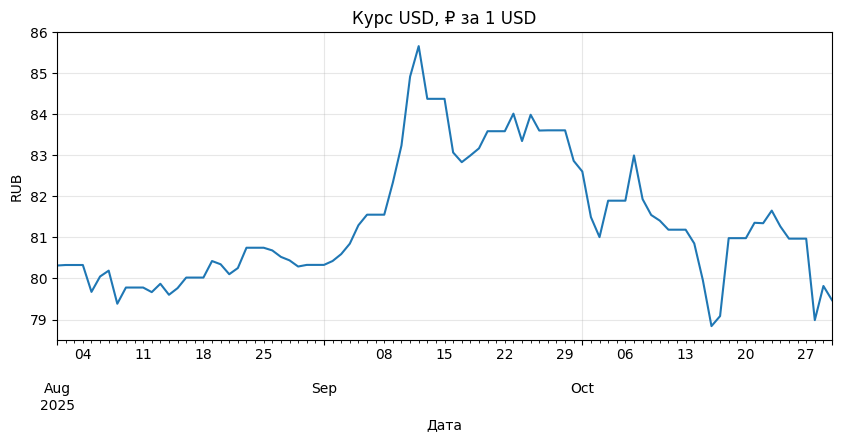

In [5]:
# --- Визуализация курса USD ---
if pd is None:
    raise RuntimeError('Для построения графика требуется pandas')

if 'df' not in globals():
    df = pd.read_csv(csv_path)

usd_df = df[df['char_code'] == 'USD'].copy()
if usd_df.empty:
    print('В выгрузке нет курса USD.')
else:
    usd_df['date'] = pd.to_datetime(usd_df['date'])
    ax = usd_df.plot(x='date', y='rate', figsize=(10, 4), legend=False)
    ax.set_title('Курс USD, ₽ за 1 USD')
    ax.set_xlabel('Дата')
    ax.set_ylabel('RUB')
    ax.grid(True, alpha=0.3)
